Task 1 - Install Spark, download datasets, create final dataframe. If you get an error regarding tar or wget, it is probably due to the Spark file being removed from the repository. Go to https://downloads.apache.org/spark/ and choose an equivalent version of Spark and Hadoop to download. So if 2.4.7 is not available, download the next version. At the time of this project creation, 2.4.7 exists.

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
!pip install pyspark==2.4.7

     |████████████████████████████████| 217.9MB 66kB/s 
     |████████████████████████████████| 204kB 11.3MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.7-py2.py3-none-any.whl size=218279468 sha256=5ac067b69c83019dc04709c3f48157e2d923e9eecadc80845aaa7b6631431a0a
  Stored in directory: /root/.cache/pip/wheels/34/1f/2e/1e7460f80acf26b08dbb8c53d7ff9e07146f2a68dd5c732be5
Successfully built pyspark


In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
from google.colab import files
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import isnan, when, count, col, lit, trim, avg, ceil
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
!wget https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv -O features.csv
!wget https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv -O labels.csv

--2021-06-09 02:03:55--  https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.67.62
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.67.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20069199 (19M) [text/csv]
Saving to: ‘features.csv’

features.csv        100%[===================>]  19.14M  30.1MB/s    in 0.6s    

2021-06-09 02:03:56 (30.1 MB/s) - ‘features.csv’ saved [20069199/20069199]

--2021-06-09 02:03:56--  https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.67.62
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.67.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1148327 (1.1M) [text/csv]
Saving to: ‘labels.csv’

labels.csv          100%[===================>]   1.09M  4.37MB/s    in 0.3s    

2021-06-09 02:03:57 (4.37 MB

In [5]:
sc = SparkSession.builder.master("local[*]").getOrCreate()

In [6]:
features = sc.read.csv('features.csv', inferSchema=True, header=True)
labels = sc.read.csv('labels.csv', inferSchema=True, header=True)

In [7]:
features.show()

+-----+----------+-------------------+--------------------+----------+--------------------+-----------+-------------------+--------------------+-----------+--------------------+---------------+-----------+-----------+-------------+----------------+--------------+----------+--------------+--------------------+-----------------+--------------------+------+-----------------+---------------+---------------------+---------------------+----------------+----------------+--------------------+------------+-------------+-------------+------------+--------------+--------------------+--------------------+------------+--------------------+---------------------+
|   id|amount_tsh|      date_recorded|              funder|gps_height|           installer|  longitude|           latitude|            wpt_name|num_private|               basin|     subvillage|     region|region_code|district_code|             lga|          ward|population|public_meeting|         recorded_by|scheme_management|         scheme

In [8]:
labels.show()

+-----+--------------------+
|   id|        status_group|
+-----+--------------------+
|69572|          functional|
| 8776|          functional|
|34310|          functional|
|67743|      non functional|
|19728|          functional|
| 9944|          functional|
|19816|      non functional|
|54551|      non functional|
|53934|      non functional|
|46144|          functional|
|49056|          functional|
|50409|          functional|
|36957|          functional|
|50495|          functional|
|53752|          functional|
|61848|          functional|
|48451|      non functional|
|58155|      non functional|
|34169|functional needs ...|
|18274|          functional|
+-----+--------------------+
only showing top 20 rows



In [9]:
print(features.count())
print(labels.count())
print(features.columns)
print(labels.columns)

59400
59400
['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']
['id', 'status_group']


In [10]:
data = features.join(labels, on='id')

Task 2 - Change column type, drop duplicated rows, remove whitespacs. If you are disconnected, please run the previous cells by clicking on this cell, going to Runtime, then clicking Run before.

In [11]:
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- amount_tsh: double (nullable = true)
 |-- date_recorded: timestamp (nullable = true)
 |-- funder: string (nullable = true)
 |-- gps_height: integer (nullable = true)
 |-- installer: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- wpt_name: string (nullable = true)
 |-- num_private: integer (nullable = true)
 |-- basin: string (nullable = true)
 |-- subvillage: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_code: integer (nullable = true)
 |-- district_code: integer (nullable = true)
 |-- lga: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- public_meeting: boolean (nullable = true)
 |-- recorded_by: string (nullable = true)
 |-- scheme_management: string (nullable = true)
 |-- scheme_name: string (nullable = true)
 |-- permit: boolean (nullable = true)
 |-- construction_year: integer (nullable

In [12]:
data = data.withColumn('region_code', col=data.region_code.cast(StringType())).\
            withColumn('district_code', col=data.district_code.cast(StringType()))

In [13]:
data.dropDuplicates(subset=['id'])
data.count()

59400

In [14]:
str_cols = [tup[0] for tup in data.dtypes if tup[1] == 'string']
for col in str_cols:
  data = data.withColumn(col, trim(data[col]))

data.show(10)

+-----+----------+-------------------+-------------------+----------+------------+-----------+------------+--------------------+-----------+--------------------+---------------+---------+-----------+-------------+---------------+----------+----------+--------------+--------------------+-----------------+--------------------+------+-----------------+---------------+---------------------+---------------------+----------+----------------+--------------+------------+-------------+-------------+------------+--------------+--------------------+--------------------+------------+--------------------+---------------------+--------------+
|   id|amount_tsh|      date_recorded|             funder|gps_height|   installer|  longitude|    latitude|            wpt_name|num_private|               basin|     subvillage|   region|region_code|district_code|            lga|      ward|population|public_meeting|         recorded_by|scheme_management|         scheme_name|permit|construction_year|extraction_t

Task 3 - Remove columns with null values more than a threshold. If you are disconnected, please run the previous cells by clicking on this cell, going to Runtime, then clicking Run before.

In [15]:
invalid_cols = [tup[0] for tup in data.dtypes if (tup[1] == 'timestamp') | (tup[1] == 'boolean')]
print(invalid_cols)

['date_recorded', 'public_meeting', 'permit']


In [ ]:
agg_row = data.select([(count(when(isnan(c) | col(c).isNull(), c))/count(c)).alias(c) for c in data.columns if c not in {'public_meeting', 'permit'} ]).collect()
agg_dict_list = [row.asDict() for row in agg_row]
agg_dict = agg_dict_list[0]

In [ ]:
col_list_drop = [key for key in agg_dict.keys() if agg_dict[key] > 0.4]
data = data.drop(*col_list_drop)

Task 4 - Group, aggregate, create pivot table. If you are disconnected, please run the previous cells by clicking on this cell, going to Runtime, then clicking Run before.

In [19]:
data.groupby('recorded_by').count().show()

+--------------------+-----+
|         recorded_by|count|
+--------------------+-----+
|GeoData Consultan...|59400|
+--------------------+-----+



In [23]:
data.groupby('water_quality').count().orderBy('count', ascending=False).show()

+------------------+-----+
|     water_quality|count|
+------------------+-----+
|              soft|50818|
|             salty| 4856|
|           unknown| 1876|
|             milky|  804|
|          coloured|  490|
|   salty abandoned|  339|
|          fluoride|  200|
|fluoride abandoned|   17|
+------------------+-----+



In [24]:
data = data.drop('recorded_by')

In [25]:
data.groupby('status_group').pivot('region').sum('amount_tsh').show()

+--------------------+---------+-------------+------+---------+------+--------+-----------+-------+--------+--------+-----+--------+-------+-------+---------+--------+---------+---------+--------+------+--------+
|        status_group|   Arusha|Dar es Salaam|Dodoma|   Iringa|Kagera|  Kigoma|Kilimanjaro|  Lindi| Manyara|    Mara|Mbeya|Morogoro| Mtwara| Mwanza|    Pwani|   Rukwa|   Ruvuma|Shinyanga| Singida|Tabora|   Tanga|
+--------------------+---------+-------------+------+---------+------+--------+-----------+-------+--------+--------+-----+--------+-------+-------+---------+--------+---------+---------+--------+------+--------+
|functional needs ...|  10280.0|          0.0|   0.0| 118400.0|   0.0|270770.0|   129248.0| 3625.0| 71315.0|   900.0|  0.0| 70005.0|36240.0|10000.0|    520.0|292980.0| 125650.0|   2200.0|  6505.0|   0.0|  4310.0|
|          functional|1125485.0|     181175.0|   0.0|5515710.0|   0.0|530725.0|  746942.25|24560.0|312745.0| 96786.0|  0.0|587642.0|52710.0|33550.0|

Task 5 - Convert categories with low frequency to Others, impute missing values. If you are disconnected, please run the previous cells by clicking on this cell, going to Runtime, then clicking Run before.

In [26]:
print(str_cols)

['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


In [ ]:
for column in str_cols:
  data.groupby(column).count().orderBy('count', ascending=False).show()
  category_values = data.groupby(column).count().collect()
  less_frequent = [cat[0] for cat in category_values if cat[1] < 1000]
  data = data.withColumn(column, when(col(column).isin(less_frequent), 'Others').otherwise(col(column)))
  # Let's see if it really worked
  data.groupby(column).count().orderBy('count', ascending=False).show()


In [32]:
data.groupby('population').count().orderBy('population').show()

+----------+-----+
|population|count|
+----------+-----+
|         0|21381|
|         1| 7025|
|         2|    4|
|         3|    4|
|         4|   13|
|         5|   44|
|         6|   19|
|         7|    3|
|         8|   23|
|         9|   11|
|        10|  163|
|        11|    7|
|        12|   43|
|        13|   12|
|        14|   18|
|        15|  193|
|        16|    8|
|        17|    6|
|        18|   18|
|        19|    3|
+----------+-----+
only showing top 20 rows



In [34]:
from pyspark.sql.functions import isnan, when, count, col, lit, trim, avg, ceil
data = data.withColumn('population', when(col('population') < 2, lit(None)).otherwise(col('population')))


In [44]:
w = Window.partitionBy(data['district_code'])
data = data.withColumn('population', when(col('population').isNull(), avg(data['population']).over(w)).otherwise(col('population')))


In [45]:
data = data.withColumn('population', ceil(data['population']))

In [46]:
data.groupby('population').count().orderBy('population').show()

+----------+-----+
|population|count|
+----------+-----+
|      null|   35|
|         2|    4|
|         3|    4|
|         4|   13|
|         5|   44|
|         6|   19|
|         7|    3|
|         8|   23|
|         9|   11|
|        10|  163|
|        11|    7|
|        12|   43|
|        13|   12|
|        14|   18|
|        15|  193|
|        16|    8|
|        17|    6|
|        18|   18|
|        19|    3|
|        20|  462|
+----------+-----+
only showing top 20 rows



Task 6 - Make visualizations. If you are disconnected, please run the previous cells by clicking on this cell, going to Runtime, then clicking Run before.

In [48]:
color_status = {'functional': 'green', 'non functional': 'red', 'functional needs repair': 'blue'}

In [49]:
cols = ['status_group', 'payment_type', 'longitude', 'latitude', 'gps_height']
df = data.select(cols).toPandas()

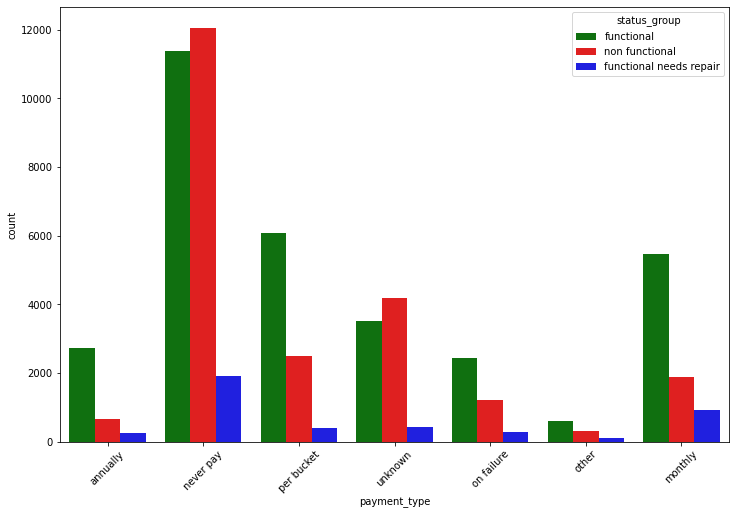

In [50]:
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(x='payment_type', hue='status_group', data=df, ax=ax, palette=color_status)
plt.xticks(rotation=45)
plt.show()

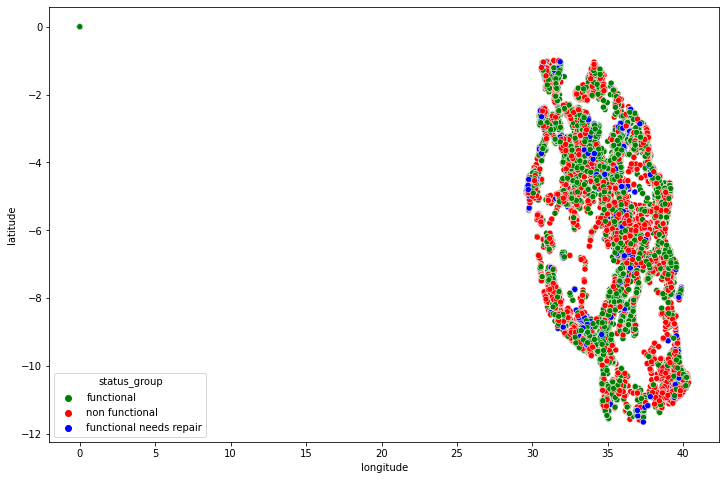

In [51]:
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x='longitude', y='latitude', data=df, ax=ax, hue='status_group', palette=color_status)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

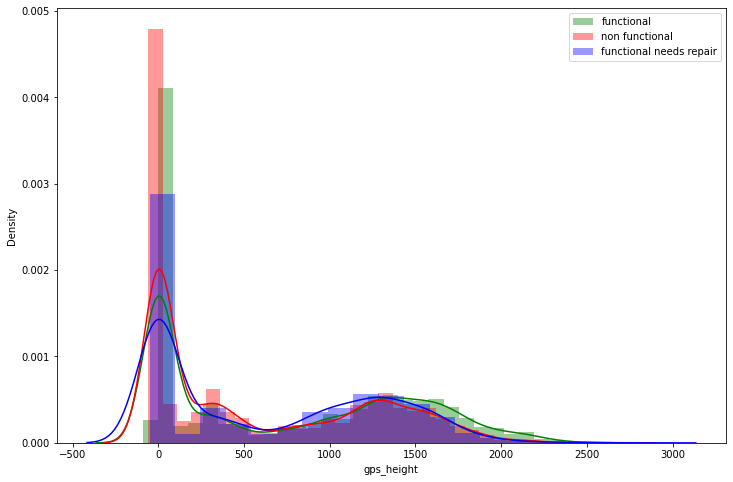

In [53]:
row_functional = df['status_group'] == 'functional'
row_non_functional = df['status_group'] == 'non functional'
row__repair = df ['status_group'] == 'functional needs repair'
col = 'gps_height'
fig, ax = plt.subplots(figsize=(12,8))
sns.distplot(df[col][row_functional], color='green', label='functional', ax=ax)
sns.distplot(df[col][row_non_functional], color='red', label='non functional', ax=ax)
sns.distplot(df[col][row__repair], color='blue', label='functional needs repair', ax=ax)
plt.legend()
plt.show()

In [54]:
data.groupby(col).count().orderBy(col).show()

+----------+-----+
|gps_height|count|
+----------+-----+
|       -90|    1|
|       -63|    2|
|       -59|    1|
|       -57|    1|
|       -55|    1|
|       -54|    1|
|       -53|    1|
|       -52|    2|
|       -51|    2|
|       -50|    5|
|       -49|    4|
|       -48|    6|
|       -47|    8|
|       -46|    6|
|       -45|    9|
|       -44|    6|
|       -43|   11|
|       -42|   13|
|       -41|   11|
|       -40|   26|
+----------+-----+
only showing top 20 rows

